In [4]:
import cv2
import pandas as pd
import numpy as np

# Charger et parser le fichier texte
def load_and_clean_data(file_path):
    # Lire le fichier texte avec tabulations
    por_data = pd.read_csv(file_path, sep='\t', low_memory=False)
    
    # Garder uniquement les lignes avec des données numériques dans les colonnes L POR X et L POR Y
    por_data = por_data[pd.to_numeric(por_data['L POR X [px]'], errors='coerce').notnull()]
    por_data = por_data[pd.to_numeric(por_data['L POR Y [px]'], errors='coerce').notnull()]
    
    # Convertir les colonnes L POR X et L POR Y en numériques
    por_data['L POR X [px]'] = pd.to_numeric(por_data['L POR X [px]'], errors='coerce')
    por_data['L POR Y [px]'] = pd.to_numeric(por_data['L POR Y [px]'], errors='coerce')
    
    return por_data

# Synchroniser les données avec les frames de la vidéo
def synchronize_data_with_video(por_data, total_frames):
    total_data_points = len(por_data)
    
    # Calculer une interpolation linéaire pour approximer une synchronisation
    frame_indices = np.linspace(0, total_data_points - 1, total_frames).astype(int)
    
    # Sélectionner les données correspondant aux frames de la vidéo
    synced_por_data = por_data.iloc[frame_indices].reset_index(drop=True)
    
    return synced_por_data

# Charger la vidéo
video_path = 'Test Your Awareness.avi'
cap = cv2.VideoCapture(video_path)

# Obtenir les propriétés de la vidéo
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Charger et nettoyer les données de point de regard
por_data_path = 'Test Your Awareness eyes data.txt'  # Le chemin du fichier texte
por_data = load_and_clean_data(por_data_path)

# Synchroniser les données avec la vidéo
synced_por_data = synchronize_data_with_video(por_data, total_frames)

# Définir la sortie vidéo sans filtre
output_path_no_filter = 'output_no_filterV1.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out_no_filter = cv2.VideoWriter(output_path_no_filter, fourcc, fps, (frame_width, frame_height))

# Définir la couleur du cercle violet (en BGR)
purple = (128, 0, 128)

# Boucle pour traiter les frames et incruster le cercle
frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Vérifier si on a une ligne de données correspondante
    if frame_idx < len(synced_por_data):
        # Extraire les coordonnées de POR pour cette frame
        por_x = synced_por_data['L POR X [px]'].iloc[frame_idx]
        por_y = synced_por_data['L POR Y [px]'].iloc[frame_idx]

        # Vérifier si les valeurs sont valides et dans les limites de l'écran
        if not np.isnan(por_x) and not np.isnan(por_y):
            if 0 <= por_x < frame_width and 0 <= por_y < frame_height:
                # Incruster le cercle violet à la position du point de regard
                print(f"Frame {frame_idx}: Cercle violet à ({por_x}, {por_y})")  # Débogage
                frame = cv2.circle(frame, (int(por_x), int(por_y)), 15, purple, 2)
            else:
                print(f"Frame {frame_idx}: Coordonnées hors cadre ({por_x}, {por_y})")  # Débogage
        else:
            print(f"Frame {frame_idx}: Coordonnées non valides ({por_x}, {por_y})")  # Débogage

    # Écrire la frame dans la vidéo sans filtre
    out_no_filter.write(frame)

    # Passer à la frame suivante
    frame_idx += 1

# Libérer les ressources
cap.release()
out_no_filter.release()
print(f"Vidéo (sans filtre) enregistrée sous {output_path_no_filter}")


Frame 0: Cercle violet à (939.7269, 636.3765)
Frame 1: Cercle violet à (921.1048, 630.3575)
Frame 2: Cercle violet à (925.5948, 642.5767)
Frame 3: Cercle violet à (925.0345, 657.6126)
Frame 4: Cercle violet à (920.3094, 650.832)
Frame 5: Cercle violet à (919.0128, 660.0189)
Frame 6: Cercle violet à (906.576, 659.1901)
Frame 7: Cercle violet à (927.7622, 626.2067)
Frame 8: Cercle violet à (948.9511, 647.8896)
Frame 9: Cercle violet à (950.6081, 636.8384)
Frame 10: Cercle violet à (926.7978, 648.4931)
Frame 11: Cercle violet à (915.1675, 653.0473)
Frame 12: Cercle violet à (935.6985, 638.4932)
Frame 13: Cercle violet à (930.4136, 649.2646)
Frame 14: Cercle violet à (927.9204, 663.1288)
Frame 15: Cercle violet à (931.887, 645.0108)
Frame 16: Cercle violet à (808.1836, 577.3885)
Frame 17: Cercle violet à (803.3457, 577.4753)
Frame 18: Cercle violet à (808.1607, 596.4488)
Frame 19: Cercle violet à (802.2591, 599.0648)
Frame 20: Cercle violet à (792.0483, 600.6367)
Frame 21: Cercle violet à 

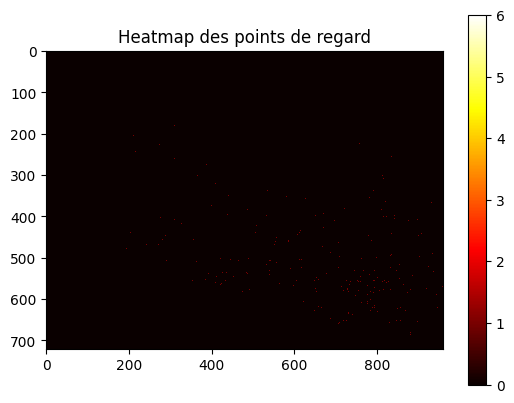

Vidéo avec filtre de Kalman enregistrée sous output_with_kalman_filter.avi
Heatmap enregistrée sous heatmap.png


In [6]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger et parser le fichier texte
def load_and_clean_data(file_path):
    # Lire le fichier texte avec tabulations
    por_data = pd.read_csv(file_path, sep='\t', low_memory=False)
    
    # Garder uniquement les lignes avec des données numériques dans les colonnes L POR X et L POR Y
    por_data = por_data[pd.to_numeric(por_data['L POR X [px]'], errors='coerce').notnull()]
    por_data = por_data[pd.to_numeric(por_data['L POR Y [px]'], errors='coerce').notnull()]
    
    # Convertir les colonnes L POR X et L POR Y en numériques
    por_data['L POR X [px]'] = pd.to_numeric(por_data['L POR X [px]'], errors='coerce')
    por_data['L POR Y [px]'] = pd.to_numeric(por_data['L POR Y [px]'], errors='coerce')
    
    return por_data

# Initialiser le filtre de Kalman
def initialize_kalman():
    kalman = cv2.KalmanFilter(4, 2)
    kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
    kalman.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
    kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03
    return kalman

# Synchroniser les données avec les frames de la vidéo
def synchronize_data_with_video(por_data, total_frames):
    total_data_points = len(por_data)
    
    # Calculer une interpolation linéaire pour approximer une synchronisation
    frame_indices = np.linspace(0, total_data_points - 1, total_frames).astype(int)
    
    # Sélectionner les données correspondant aux frames de la vidéo
    synced_por_data = por_data.iloc[frame_indices].reset_index(drop=True)
    
    return synced_por_data

# Charger la vidéo
video_path = 'Test Your Awareness.avi'
cap = cv2.VideoCapture(video_path)

# Obtenir les propriétés de la vidéo
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Charger et nettoyer les données de point de regard
por_data_path = 'Test Your Awareness eyes data.txt'  # Le chemin du fichier texte
por_data = load_and_clean_data(por_data_path)

# Synchroniser les données avec la vidéo
synced_por_data = synchronize_data_with_video(por_data, total_frames)

# Définir la sortie vidéo avec filtre de Kalman
output_path_filter = 'output_with_kalman_filter.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out_filter = cv2.VideoWriter(output_path_filter, fourcc, fps, (frame_width, frame_height))

# Initialiser le filtre de Kalman
kalman = initialize_kalman()

# Définir la couleur du cercle violet (en BGR)
purple = (128, 0, 128)

# Initialiser les données pour la heatmap
heatmap_data = np.zeros((frame_height, frame_width))

# Boucle pour traiter les frames et incruster le cercle avec le filtre de Kalman
frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Vérifier si on a une ligne de données correspondante
    if frame_idx < len(synced_por_data):
        # Extraire les coordonnées de POR pour cette frame
        por_x = synced_por_data['L POR X [px]'].iloc[frame_idx]
        por_y = synced_por_data['L POR Y [px]'].iloc[frame_idx]

        # Vérifier si les valeurs sont valides et dans les limites de l'écran
        if not np.isnan(por_x) and not np.isnan(por_y):
            if 0 <= por_x < frame_width and 0 <= por_y < frame_height:
                # Appliquer le filtre de Kalman
                measurement = np.array([[np.float32(por_x)], [np.float32(por_y)]])
                kalman.correct(measurement)
                prediction = kalman.predict()

                # Extraire les coordonnées prédites pour lissage
                smoothed_x = int(prediction[0][0])  # Corrigé pour extraire l'élément
                smoothed_y = int(prediction[1][0])  # Corrigé pour extraire l'élément

                # Limiter les coordonnées aux dimensions de l'écran
                smoothed_x = max(0, min(smoothed_x, frame_width - 1))
                smoothed_y = max(0, min(smoothed_y, frame_height - 1))

                # Incruster le cercle violet à la position lissée
                frame = cv2.circle(frame, (smoothed_x, smoothed_y), 15, purple, 2)

                # Accumuler les données pour la heatmap
                heatmap_data[smoothed_y, smoothed_x] += 1

    # Écrire la frame dans la vidéo avec le filtre de Kalman
    out_filter.write(frame)

    # Passer à la frame suivante
    frame_idx += 1

# Libérer les ressources vidéo
cap.release()
out_filter.release()

# Générer la heatmap à partir des données accumulées
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap des points de regard')
plt.savefig('heatmap.png')
plt.show()

print(f"Vidéo avec filtre de Kalman enregistrée sous {output_path_filter}")
print("Heatmap enregistrée sous heatmap.png")


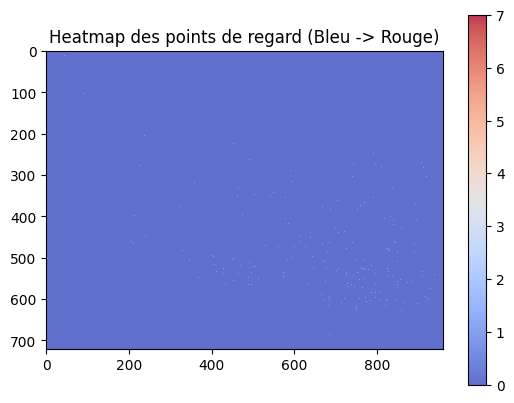

Vidéo avec filtre de Kalman ajustée enregistrée sous output_with_kalman_filter_centered.avi
Heatmap enregistrée sous heatmap_adjusted_large_spots.png


In [9]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger et parser le fichier texte
def load_and_clean_data(file_path):
    # Lire le fichier texte avec tabulations
    por_data = pd.read_csv(file_path, sep='\t', low_memory=False)
    
    # Garder uniquement les lignes avec des données numériques dans les colonnes L POR X et L POR Y
    por_data = por_data[pd.to_numeric(por_data['L POR X [px]'], errors='coerce').notnull()]
    por_data = por_data[pd.to_numeric(por_data['L POR Y [px]'], errors='coerce').notnull()]
    
    # Convertir les colonnes L POR X et L POR Y en numériques
    por_data['L POR X [px]'] = pd.to_numeric(por_data['L POR X [px]'], errors='coerce')
    por_data['L POR Y [px]'] = pd.to_numeric(por_data['L POR Y [px]'], errors='coerce')
    
    return por_data

# Initialiser le filtre de Kalman
def initialize_kalman():
    kalman = cv2.KalmanFilter(4, 2)
    kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
    kalman.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
    kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.01  # Lissage doux
    return kalman

# Synchroniser les données avec les frames de la vidéo
def synchronize_data_with_video(por_data, total_frames):
    total_data_points = len(por_data)
    
    # Calculer une interpolation linéaire pour approximer une synchronisation
    frame_indices = np.linspace(0, total_data_points - 1, total_frames).astype(int)
    
    # Sélectionner les données correspondant aux frames de la vidéo
    synced_por_data = por_data.iloc[frame_indices].reset_index(drop=True)
    
    return synced_por_data

# Charger la vidéo
video_path = 'Test Your Awareness.avi'
cap = cv2.VideoCapture(video_path)

# Obtenir les propriétés de la vidéo
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Charger et nettoyer les données de point de regard
por_data_path = 'Test Your Awareness eyes data.txt'  # Le chemin du fichier texte
por_data = load_and_clean_data(por_data_path)

# Synchroniser les données avec la vidéo
synced_por_data = synchronize_data_with_video(por_data, total_frames)

# Définir la sortie vidéo avec filtre de Kalman
output_path_filter = 'output_with_kalman_filter_centered.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out_filter = cv2.VideoWriter(output_path_filter, fourcc, fps, (frame_width, frame_height))

# Initialiser le filtre de Kalman
kalman = initialize_kalman()

# Définir la couleur du cercle violet (en BGR)
purple = (128, 0, 128)

# Initialiser les données pour la heatmap
heatmap_data = np.zeros((frame_height, frame_width))

# Boucle pour traiter les frames et incruster le cercle avec le filtre de Kalman
frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Vérifier si on a une ligne de données correspondante
    if frame_idx < len(synced_por_data):
        # Extraire les coordonnées de POR pour cette frame
        por_x = synced_por_data['L POR X [px]'].iloc[frame_idx]
        por_y = synced_por_data['L POR Y [px]'].iloc[frame_idx]

        # Vérifier si les valeurs sont valides et dans les limites de l'écran
        if not np.isnan(por_x) and not np.isnan(por_y):
            if 0 <= por_x < frame_width and 0 <= por_y < frame_height:
                # Appliquer le filtre de Kalman
                measurement = np.array([[np.float32(por_x)], [np.float32(por_y)]])
                kalman.correct(measurement)
                prediction = kalman.predict()

                # Extraire les coordonnées prédites pour lissage
                smoothed_x = int(prediction[0][0])  # Corrigé pour extraire l'élément
                smoothed_y = int(prediction[1][0]) - 20  # Déplacement de 20 pixels vers le haut

                # Limiter les coordonnées aux dimensions de l'écran
                smoothed_x = max(0, min(smoothed_x, frame_width - 1))
                smoothed_y = max(0, min(smoothed_y, frame_height - 1))

                # Incruster le cercle violet à la position lissée
                frame = cv2.circle(frame, (smoothed_x, smoothed_y), 15, purple, 2)

                # Accumuler les données pour la heatmap
                heatmap_data[smoothed_y, smoothed_x] += 1

    # Écrire la frame dans la vidéo avec le filtre de Kalman
    out_filter.write(frame)

    # Passer à la frame suivante
    frame_idx += 1

# Libérer les ressources vidéo
cap.release()
out_filter.release()

# Générer la heatmap avec un dégradé bleu-rouge et fond blanc, avec de grosses tâches visibles
plt.imshow(heatmap_data, cmap='coolwarm', interpolation='nearest', alpha=0.8)
plt.colorbar()
plt.title('Heatmap des points de regard (Bleu -> Rouge)')
plt.savefig('heatmap_adjusted_large_spots.png', dpi=200)  # Augmenter la résolution pour plus de visibilité
plt.show()

print(f"Vidéo avec filtre de Kalman ajustée enregistrée sous {output_path_filter}")
print("Heatmap enregistrée sous heatmap_adjusted_large_spots.png")
